In [1]:
import tess_cpm
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS

In [21]:
fits_file = "eclipsing_binaries/tess-s0005-1-1_65.170600_-1.740100_100x100_astrocut.fits"
# fits_file = "tess-s0002-4-2_83.272000_-69.508733_64x64_astrocut.fits"

In [22]:
cpm = tess_cpm.CPM(fits_file, remove_bad=True)

Removing bad values by using the TESS provided "QUALITY" array


In [24]:
cpm.set_poly_model(1, 4, 5)
cpm.set_target(50, 50)
# cpm.set_target(34, 71)  # Bright region bottom-right
# cpm.set_target(36, 11)
cpm.set_exclusion(10)
cpm.set_predictor_pixels(256)

In [25]:
cpm.lsq(0.5, rescale=True, polynomials=True)

False, not None
False, None


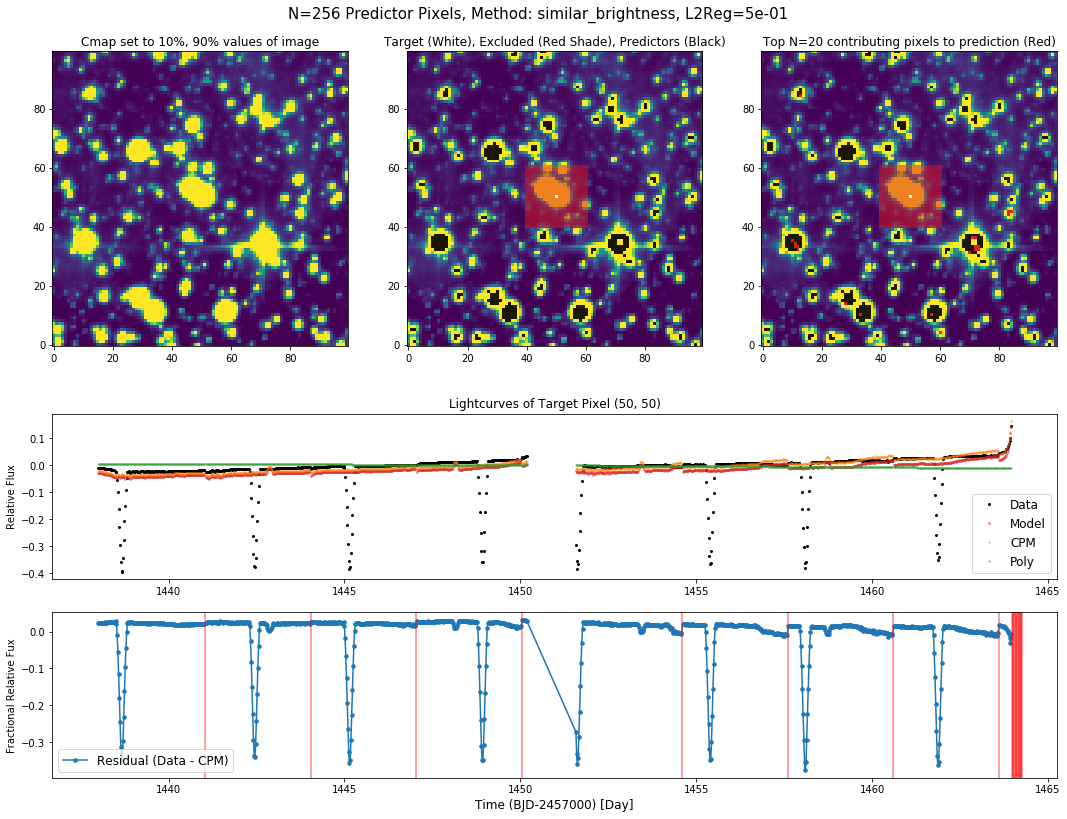

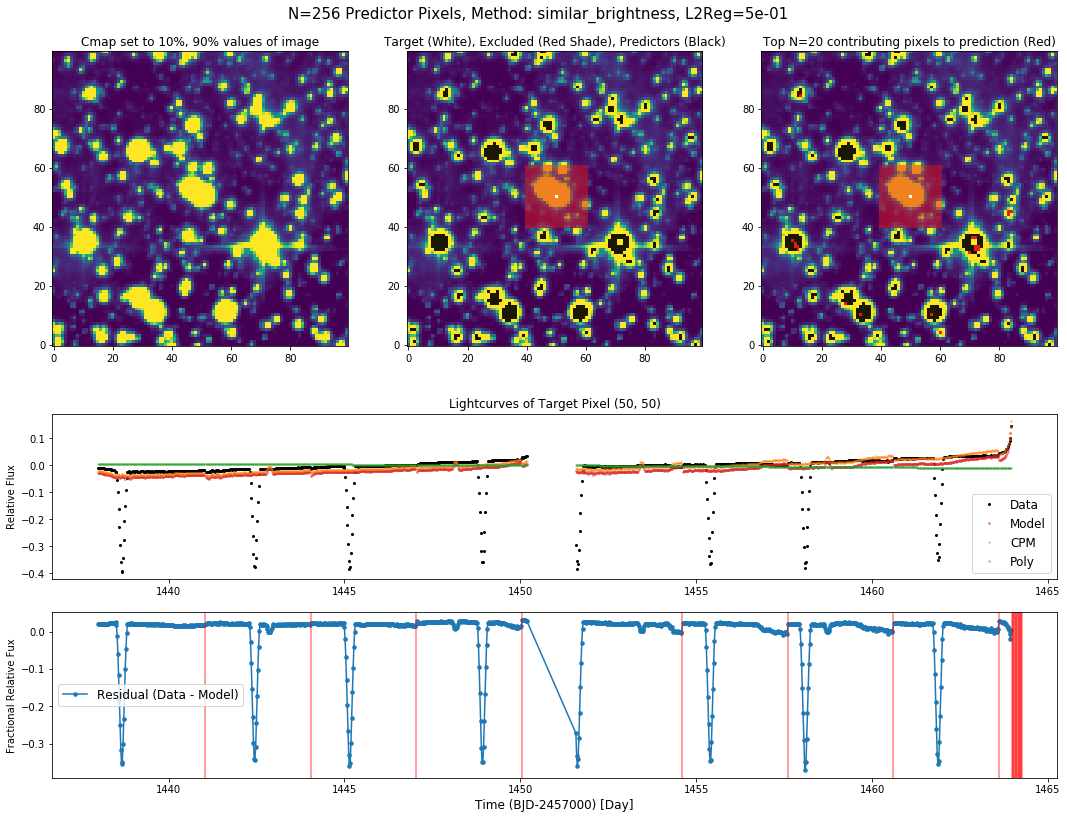

In [26]:
tess_cpm.summary_plot(cpm, 20, subtract_polynomials=False)
tess_cpm.summary_plot(cpm, 20, subtract_polynomials=True)

In [ ]:
plt.figure(figsize=(15, 10))
plt.plot(cpm.time, cpm.target_fluxes, ".-", color="k")
for dump in cpm.dump_times:
    plt.axvline(dump, color="red", alpha=0.5)

In [ ]:
from IPython.display import HTML
import matplotlib.animation as animation
cpm.entire_image(0.5, rescale=True, polynomials=True)
diff = cpm.im_diff
upscaled_diff = cpm.pixel_medians*cpm.im_diff

fig, axes = plt.subplots(1, 3, figsize=(18, 18))

ims = []
for i in range(0, diff.shape[0], 10):
    im1 = axes[0].imshow(cpm.im_fluxes[i], origin="lower", animated=True,
                        vmin=np.percentile(cpm.im_fluxes[0], 10), vmax=np.percentile(cpm.im_fluxes[0], 90))
    im2 = axes[1].imshow(diff[i], origin="lower", animated=True,
                   vmin=np.percentile(diff, 1), vmax=np.percentile(diff, 99));
    im3 = axes[2].imshow(upscaled_diff[i], origin="lower", animated=True,
                   vmin=np.percentile(upscaled_diff, 1), vmax=np.percentile(upscaled_diff, 99));
    ims.append([im1, im2, im3]);
fig.colorbar(im1, ax=axes[0], fraction=0.046)
fig.colorbar(im2, ax=axes[1], fraction=0.046)
fig.colorbar(im3, ax=axes[2], fraction=0.046)
    
ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000);

HTML(ani.to_jshtml())
